### Download and unzip the COCO dataset

In [ ]:
!mkdir /content/coco
%cd /content/coco
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

/content/coco
--2024-11-12 09:25:17--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.9.145, 52.216.33.161, 54.231.129.49, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.9.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  38.8MB/s    in 7m 59s  

2024-11-12 09:33:16 (38.5 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-11-12 09:33:16--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.234.89, 52.216.240.172, 52.217.172.73, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.234.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===============

In [ ]:
!unzip train2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip


Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/00000019

 ## Load and Parse COCO Annotations
Use the pycocotools library, which provides easy access to the COCO dataset structure. If it’s not installed, install it with:

In [ ]:
!pip install pycocotools


In [ ]:
!pip install tensorflow opencv-python-headless

##  Sample load and parse bounding boxes and class IDs from the COCO annotation files.

loading annotations into memory...
Done (t=28.19s)
creating index...
index created!


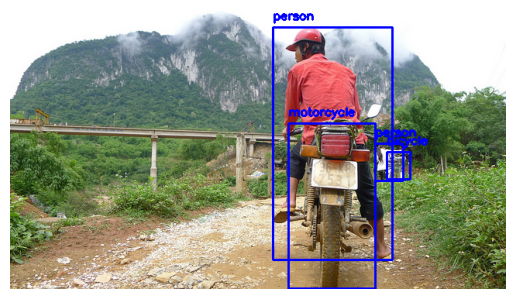

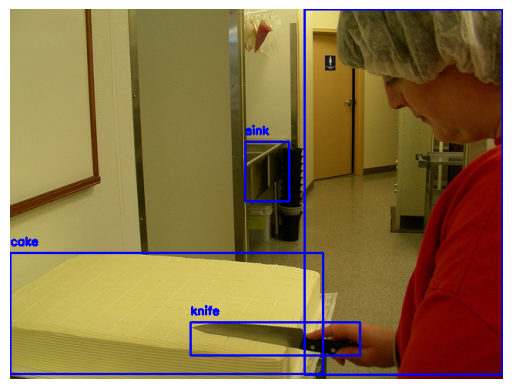

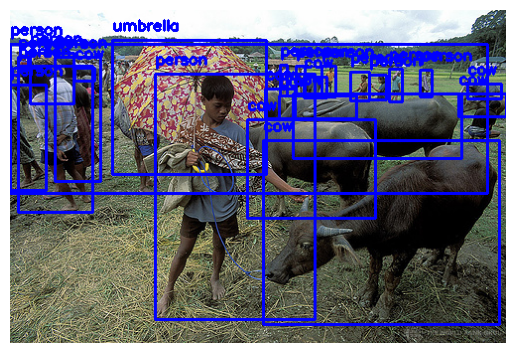

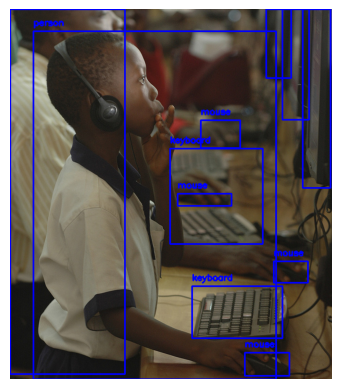

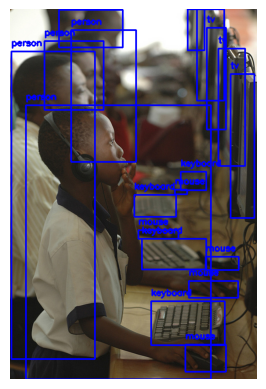

In [3]:
from pycocotools.coco import COCO
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Define paths to the annotation file and images directory
ANNOTATION_FILE = '/content/coco/annotations/instances_train2017.json'
IMAGE_DIR = '/content/coco/train2017'

# Initialize COCO API for instance annotations
coco = COCO(ANNOTATION_FILE)

# Function to load image and its annotations
def load_image_and_annotations(image_id):
    # Get image information
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(IMAGE_DIR, image_info['file_name'])
    image = cv2.imread(image_path)

    # Load annotations (bounding boxes and category IDs)
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    boxes = []
    class_ids = []
    for ann in anns:
        bbox = ann['bbox']
        category_id = ann['category_id']

        # COCO bounding box format is [x, y, width, height]
        x, y, width, height = bbox
        boxes.append([x, y, x + width, y + height])
        class_ids.append(category_id)

    return image, boxes, class_ids

# Display an example image with bounding boxes
def display_image_with_boxes(image, boxes, class_ids):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = coco.loadCats(class_ids[i])[0]["name"]
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Example usage
image_ids = coco.getImgIds()
for image_id in image_ids[:5]:  # Display the first 5 images
    image, boxes, class_ids = load_image_and_annotations(image_id)
    display_image_with_boxes(image.copy(), boxes, class_ids)


## Implementation:

- Data Preparation: Preprocess the dataset by resizing images, normalizing
pixel values, and, if necessary, labeling bounding boxes for objects.
- Model Building: Implement the selected object detection algorithm using
appropriate libraries (e.g., OpenCV for HOG-SVM, TensorFlow/Keras for
YOLO or SSD).
- Training the Model: Use the training data to train the object detection
model. For deep learning methods, fine-tune hyperparameters (e.g.,
learning rate, batch size, epochs) to optimize model performance.
- Testing: Evaluate the model on a test set to assess its detection capabilities.
Ensure to capture edge cases where the model may struggle.

In [4]:
# Import Libraries

import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import defaultdict

##  Load YOLO and SSD Models  

Use pre-trained Algorithm

In [5]:
# Load YOLO and SSD models from TensorFlow Hub
ssd_model_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
ssd_model = hub.load(ssd_model_url)

yolo_model_url = "https://tfhub.dev/tensorflow/efficientdet/d0/1"  # Replace with actual YOLO model URL if available
yolo_model = hub.load(yolo_model_url)


## Data Preparation: Load and Preprocess Images
Load images from the COCO dataset directory, resize them to the target model input size, and normalize them.

In [6]:
# Function to preprocess a single image
def preprocess_image(image, target_size=(210, 210)):
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Generator function to load images in batches
def load_images_in_batches(image_dir, batch_size=2, target_size=(210, 210)):
    file_list = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
    for i in range(0, len(file_list), batch_size):
        batch_files = file_list[i:i + batch_size]
        images = []
        for filename in batch_files:
            img_path = os.path.join(image_dir, filename)
            image = cv2.imread(img_path)
            if image is not None:
                images.append(preprocess_image(image, target_size))
        yield np.array(images)


## Run Object Detection and Evaluation for YOLO and SSD
This function will run detection on both YOLO and SSD models, recording the time taken for each model and calculating basic metrics.

In [7]:
def evaluate_model(model, image_dir, model_name, batch_size=4, score_threshold=0.5):
    all_boxes, all_classes = [], []
    class_count = defaultdict(int)
    total_time = 0

    # Use a generator to load images in batches
    for batch_images in load_images_in_batches(image_dir, batch_size=batch_size):
        start_time = time.time()

        for image in batch_images:
            # Add a batch dimension to the single image
            image = np.expand_dims(image, axis=0)

            # Run inference on the single image
            predictions = model(image)

            pred_boxes = predictions['detection_boxes'][0].numpy()
            pred_classes = predictions['detection_classes'][0].numpy().astype(int)
            pred_scores = predictions['detection_scores'][0].numpy()

            # Filter predictions by score threshold
            valid_boxes = []
            valid_classes = []
            for i in range(len(pred_scores)):
                if pred_scores[i] >= score_threshold:
                    valid_boxes.append(pred_boxes[i])
                    valid_classes.append(pred_classes[i])
                    class_count[pred_classes[i]] += 1

            all_boxes.append(valid_boxes)
            all_classes.append(valid_classes)

        inference_time = time.time() - start_time
        total_time += inference_time

        # Clear memory after processing each batch
        del batch_images, predictions

    avg_time_per_image = total_time / len(all_boxes)
    print(f"Average Inference Time for {model_name}: {avg_time_per_image:.4f} seconds per image")

    return all_boxes, all_classes, class_count, avg_time_per_image

### Run Evaluation for YOLO and SSD Models

In [8]:
# Directory containing COCO validation images
TEST_IMAGE_DIR = '/content/coco/val2017'

# Evaluate YOLO
print("Evaluating YOLO...")
yolo_boxes, yolo_classes, yolo_class_count, yolo_time = evaluate_model(
    yolo_model, TEST_IMAGE_DIR, "YOLO", batch_size=4
)

# Evaluate SSD
print("Evaluating SSD...")
ssd_boxes, ssd_classes, ssd_class_count, ssd_time = evaluate_model(
    ssd_model, TEST_IMAGE_DIR, "SSD", batch_size=4
)


Evaluating YOLO...
Average Inference Time for YOLO: 0.7790 seconds per image
Evaluating SSD...
Average Inference Time for SSD: 0.1177 seconds per image


## Plot and Compare Results
Plot example predictions to visually compare the output of YOLO and SSD.

Running inference and visualizing results...


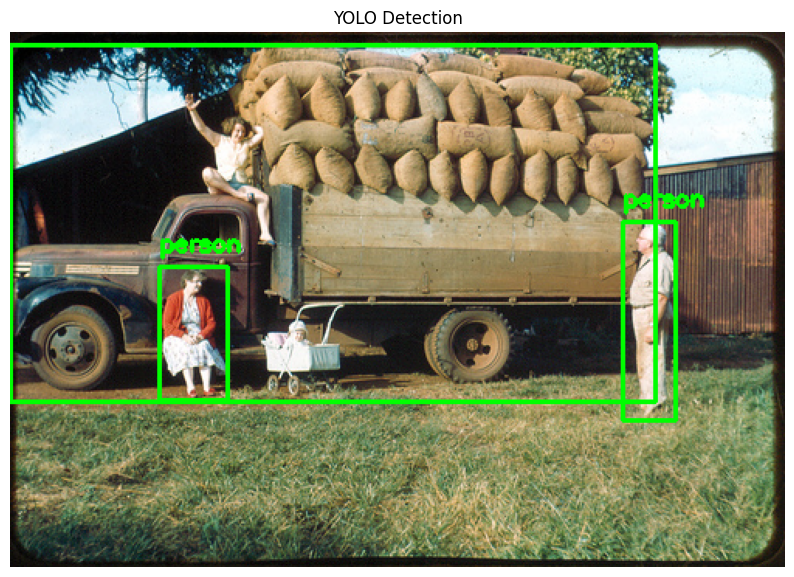

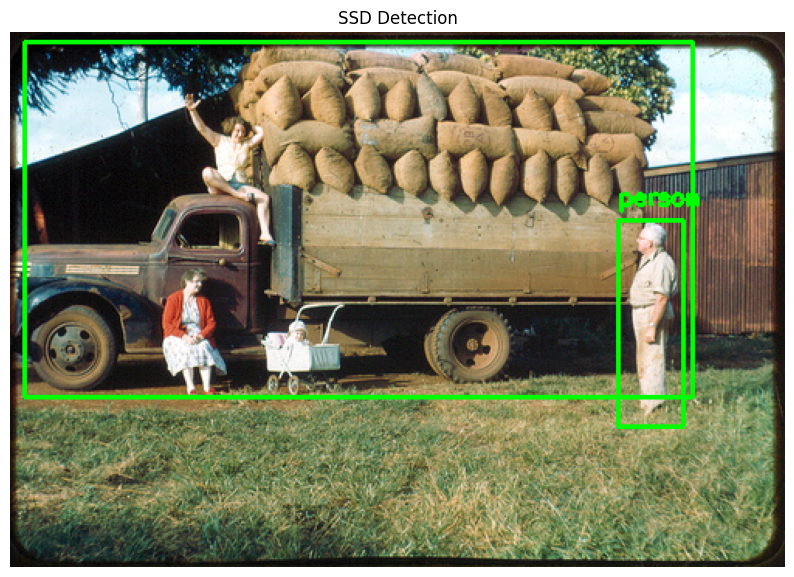

In [14]:
# Define COCO class names (full list)
COCO_CLASS_NAMES = {
    0: "background", 1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane",
    6: "bus", 7: "train", 8: "truck", 9: "boat", 10: "traffic light",
    11: "fire hydrant", 12: "stop sign", 13: "parking meter", 14: "bench", 15: "bird",
    16: "cat", 17: "dog", 18: "horse", 19: "sheep", 20: "cow",
    21: "elephant", 22: "bear", 23: "zebra", 24: "giraffe", 25: "backpack",
    26: "umbrella", 27: "handbag", 28: "tie", 29: "suitcase", 30: "frisbee",
    31: "skis", 32: "snowboard", 33: "sports ball", 34: "kite", 35: "baseball bat",
    36: "baseball glove", 37: "skateboard", 38: "surfboard", 39: "tennis racket", 40: "bottle",
    41: "wine glass", 42: "cup", 43: "fork", 44: "knife", 45: "spoon",
    46: "bowl", 47: "banana", 48: "apple", 49: "sandwich", 50: "orange",
    51: "broccoli", 52: "carrot", 53: "hot dog", 54: "pizza", 55: "donut",
    56: "cake", 57: "chair", 58: "couch", 59: "potted plant", 60: "bed",
    61: "dining table", 62: "toilet", 63: "TV", 64: "laptop", 65: "mouse",
    66: "remote", 67: "keyboard", 68: "cell phone", 69: "microwave", 70: "oven",
    71: "toaster", 72: "sink", 73: "refrigerator", 74: "book", 75: "clock",
    76: "vase", 77: "scissors", 78: "teddy bear", 79: "hair drier", 80: "toothbrush"
}

def plot_detections(image, boxes, classes, class_names, title):
    """
    Draws bounding boxes and class labels on an image.

    Parameters:
    - image: np.array, the input image.
    - boxes: list of bounding boxes with each box in the format [ymin, xmin, ymax, xmax].
    - classes: list of class IDs corresponding to each bounding box.
    - class_names: dict mapping class IDs to class names.
    - title: str, the title for the plot.
    """
    h, w, _ = image.shape
    for i in range(len(boxes)):
        ymin, xmin, ymax, xmax = boxes[i]
        # Scale box coordinates to the image dimensions
        xmin, xmax, ymin, ymax = int(xmin * w), int(xmax * w), int(ymin * h), int(ymax * h)

        # Draw rectangle around detected object
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Get class name, or default to "Unknown" if not found
        label = f"{class_names.get(classes[i], 'Unknown')}"
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image with detections
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load a test image from the COCO dataset
TEST_IMAGE_DIR = '/content/coco/train2017'
test_image_path = os.path.join(TEST_IMAGE_DIR, os.listdir(TEST_IMAGE_DIR)[0])
image = cv2.imread(test_image_path)

# Run the models on the test image and obtain the results
print("Running inference and visualizing results...")

# Evaluate YOLO on a single image
yolo_predictions = yolo_model(np.expand_dims(image, axis=0))
yolo_boxes = yolo_predictions['detection_boxes'][0].numpy()
yolo_classes = yolo_predictions['detection_classes'][0].numpy().astype(int)
yolo_scores = yolo_predictions['detection_scores'][0].numpy()

# Filter YOLO predictions by score threshold
yolo_filtered_boxes = [yolo_boxes[i] for i in range(len(yolo_scores)) if yolo_scores[i] > 0.5]
yolo_filtered_classes = [yolo_classes[i] for i in range(len(yolo_scores)) if yolo_scores[i] > 0.5]

# Visualize YOLO results
plot_detections(image.copy(), yolo_filtered_boxes, yolo_filtered_classes, COCO_CLASS_NAMES, "YOLO Detection")

# Evaluate SSD on a single image
ssd_predictions = ssd_model(np.expand_dims(image, axis=0))
ssd_boxes = ssd_predictions['detection_boxes'][0].numpy()
ssd_classes = ssd_predictions['detection_classes'][0].numpy().astype(int)
ssd_scores = ssd_predictions['detection_scores'][0].numpy()

# Filter SSD predictions by score threshold
ssd_filtered_boxes = [ssd_boxes[i] for i in range(len(ssd_scores)) if ssd_scores[i] > 0.5]
ssd_filtered_classes = [ssd_classes[i] for i in range(len(ssd_scores)) if ssd_scores[i] > 0.5]

# Visualize SSD results
plot_detections(image.copy(), ssd_filtered_boxes, ssd_filtered_classes, COCO_CLASS_NAMES, "SSD Detection")


CONCLUSION : Based on my result the SSD model a while in rendering the result while Yolo model make a instant recognition of the image based on the ID of it its not accurate becouse of the model that i used which is a pre trained one not a costom model. But for the result Yolo takes the lead in which model can be used and more reliable .